In [1]:
import sys
sys.path.append("c:/users/david/desktop/sandbox")
import pandas as pd
import numpy as np
from pyrecs.train import lightfm_wrapper
from lenskit.datasets import ML100K

%load_ext autoreload
%autoreload 2

c:\users\david\desktop\sandbox\pyrecs\env\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
ml100k = ML100K('../data/movielens-100k')

# Pure CF

In [3]:
ratings = ml100k.ratings.sort_values(by='timestamp')
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['user'] = ratings['user'].astype(str)
ratings['item'] = ratings['item'].astype(str)

print(ratings['timestamp'].describe(datetime_is_numeric=True))
print(ratings.shape)
ratings.head()

count                           100000
mean     1997-12-31 00:40:51.488619904
min                1997-09-20 03:05:10
25%         1997-11-13 19:18:29.500000
50%                1997-12-22 21:42:24
75%                1998-02-23 18:53:04
max                1998-04-22 23:10:38
Name: timestamp, dtype: object
(100000, 4)


,user,item,rating,timestamp
214,259,255,4.0,1997-09-20 03:05:10
83965,259,286,4.0,1997-09-20 03:05:27
43027,259,298,4.0,1997-09-20 03:05:54
21396,259,185,4.0,1997-09-20 03:06:21
82655,259,173,4.0,1997-09-20 03:07:23


In [4]:
train_df = ratings.iloc[:90000].copy()
test_df = ratings.iloc[90000:].copy()

train_df.shape, test_df.shape

((90000, 4), (10000, 4))

In [5]:
train_df['user'].nunique(), test_df['user'].nunique(), len(set(train_df['user'].unique()) & set(test_df['user'].unique()))

(867, 166, 90)

In [6]:
train_df['item'].nunique(), test_df['item'].nunique(), len(set(train_df['item'].unique()) & set(test_df['item'].unique()))

(1637, 1343, 1298)

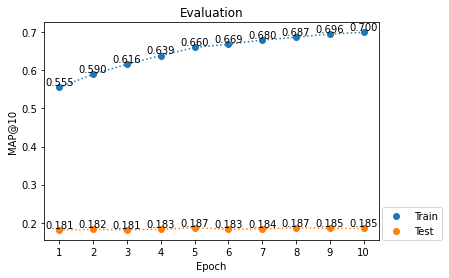

Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.74s/it]


In [9]:
model_kwargs = {
    'no_components':32,
    'learning_rate':0.05,
    'loss':'warp',
    'random_state':42
}
preprocess_kwargs = {
    'users_col':'user',
    'items_col':'item',
    'interactions_type':'ones',
    'remove_factor_biases':False
}
train_kwargs = {
    'num_epochs':10,
    'num_threads':1,
    'eval_epochs':'all',
    'plot':True
}
predict_kwargs = {
    'predict_n_recs':10,
    'tfrs_prediction_batch_size':128,
    'n_recs':10
}
postprocess_kwargs = {
    'remove_train_interactions_from_test':True,
    'fill_most_popular_items':True,
    'n_recs':10
}
lfm = lightfm_wrapper.LightFM(preprocess_kwargs=preprocess_kwargs,
                              model_kwargs=model_kwargs, 
                              train_kwargs=train_kwargs,
                              predict_kwargs=predict_kwargs,
                              postprocess_kwargs=postprocess_kwargs)

lfm.run(train_df=train_df, test_df=test_df)

In [10]:
print(len(lfm.train_dict), len(lfm.predictions_dict['train']), len(set([str(v) for v in lfm.predictions_dict['train'].values()])))
print(len(lfm.test_dict), len(lfm.predictions_dict['test']), len(set([str(v) for v in lfm.predictions_dict['test'].values()])))

867 867 867
166 166 74


# Hybrid CF

In [12]:
users = ml100k.users.reset_index()
users['user'] = users['user'].astype(str)
users['user_copy'] = users['user'].copy()
users['occupation'] = users['occupation'].astype(str)
print(users.shape)
display(users.head())


movies = ml100k.movies.reset_index()
movies['item'] = movies['item'].astype(str)
movies['item_copy'] = movies['item'].copy()
columns = [c for c in movies.columns if c not in ['item','title','release','vidrelease','imdb','item_copy']]
ind2col = dict(zip(range(len(columns)), columns))
movies['genres'] = movies[columns].apply(lambda x: [ind2col[i] for i in np.where(x != 0)[0]], axis=1)
movies.drop(columns, axis=1, inplace=True)

def extract_year(x):
    try:
        return int(x.split('(')[-1].rstrip(')'))
    except:
        return 0
movies['year'] = movies['title'].apply(extract_year)

print(movies.shape)
display(movies.head())

(943, 6)


,user,age,gender,occupation,zip,user_copy
0,1,24,M,technician,85711,1
1,2,53,F,other,94043,2
2,3,23,M,writer,32067,3
3,4,24,M,technician,43537,4
4,5,33,F,other,15213,5


(1682, 8)


,item,title,release,vidrelease,imdb,item_copy,genres,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1,"[Animation, Children's, Comedy]",1995
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,2,"[Action, Adventure, Thriller]",1995
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,3,[Thriller],1995
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,4,"[Action, Comedy, Drama]",1995
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),5,"[Crime, Drama, Thriller]",1995


In [13]:
cols = ['age','gender','occupation','user_copy','user']
train_user_features_dict = users[users['user'].isin(train_df['user'].unique())][cols].set_index('user').to_dict(orient='index')
test_user_features_dict = users[users['user'].isin(test_df['user'].unique()) 
                                & ~users['user'].isin(train_df['user'].unique())][cols].set_index('user').to_dict(orient='index')

len(train_user_features_dict), len(test_user_features_dict)

(867, 76)

In [14]:
cols = ['genres','year','item_copy','item']
train_item_features_dict = movies[movies['item'].isin(train_df['item'].unique())][cols].set_index('item').to_dict(orient='index')
test_item_features_dict = movies[movies['item'].isin(test_df['item'].unique()) 
                                & ~movies['item'].isin(train_df['item'].unique())][cols].set_index('item').to_dict(orient='index')

len(train_item_features_dict), len(test_item_features_dict)

(1637, 45)

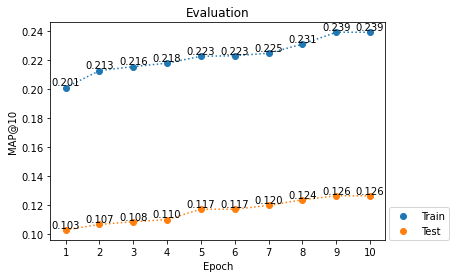

Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.52s/it]


In [15]:
model_kwargs = {
    'no_components':32,
    'learning_rate':0.05,
    'loss':'warp',
    'random_state':42
}
preprocess_kwargs = {
    'users_col':'user',
    'items_col':'item',
    'interactions_type':'ones',
    'normalize_features':True,
    'remove_factor_biases':False
}
train_kwargs = {
    'num_epochs':10,
    'num_threads':1,
    'eval_epochs':'all',
    'plot':True
}
predict_kwargs = {
    'predict_n_recs':10,
    'tfrs_prediction_batch_size':128,
    'n_recs':10
}
postprocess_kwargs = {
    'remove_train_interactions_from_test':True,
    'fill_most_popular_items':True,
    'n_recs':10
}
lfm = lightfm_wrapper.LightFM(preprocess_kwargs=preprocess_kwargs,
                              model_kwargs=model_kwargs, 
                              train_kwargs=train_kwargs,
                              predict_kwargs=predict_kwargs,
                              postprocess_kwargs=postprocess_kwargs)

lfm.run(train_df=train_df, test_df=test_df,
        train_user_features_dict=train_user_features_dict, 
        train_item_features_dict=train_item_features_dict,
        test_user_features_dict=test_user_features_dict, 
        test_item_features_dict=test_item_features_dict)

In [16]:
print(len(lfm.train_dict), len(lfm.predictions_dict['train']), len(set([str(v) for v in lfm.predictions_dict['train'].values()])))
print(len(lfm.test_dict), len(lfm.predictions_dict['test']), len(set([str(v) for v in lfm.predictions_dict['test'].values()])))

867 867 1
166 166 71
